In [1]:
import numpy as np
import pandas as pd
import os
import shutil
import time
import datetime
import calendar
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from easydict import EasyDict as ed

In [2]:
cdf = pd.read_csv('CAISO-20170701-20201030.csv', index_col=0, parse_dates=['start_dt', 'end_dt'])

In [3]:
edf = pd.read_csv('EIA-20180701-20201109.csv', index_col=0, parse_dates=['dt'])

In [4]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28232 entries, 0 to 28231
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   start_dt                  28232 non-null  datetime64[ns, UTC]
 1   end_dt                    28232 non-null  datetime64[ns, UTC]
 2   total_integrated_load_MW  28232 non-null  int64              
 3   solar_generation_MW       28232 non-null  float64            
 4   wind_generation_MW        28232 non-null  float64            
dtypes: datetime64[ns, UTC](2), float64(2), int64(1)
memory usage: 1.3 MB


In [5]:
edf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20689 entries, 0 to 20688
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   dt             20689 non-null  datetime64[ns, UTC]
 1   demand_MWh     20689 non-null  int64              
 2   wind_gen_MWh   20689 non-null  int64              
 3   solar_gen_MWh  20689 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(3)
memory usage: 808.2 KB


In [6]:
# merge and clean the df

In [7]:
df = cdf.merge(edf, left_on='start_dt', right_on='dt')

In [8]:
df = (df.drop(columns=['start_dt', 'end_dt'])
        .rename(columns={'total_integrated_load_MW': 'caiso_load',
                         'solar_generation_MW': 'caiso_solar',
                         'wind_generation_MW': 'caiso_wind',
                         'demand_MWh': 'eia_load',
                         'solar_gen_MWh': 'eia_solar',
                         'wind_gen_MWh': 'eia_wind'})
       .reindex(columns=['dt', 'caiso_load', 'eia_load', 'caiso_solar', 'eia_solar', 'caiso_wind', 'eia_wind'])
       .astype({'caiso_load': float, 'eia_load': float, 'eia_solar': float, 'eia_wind': float})
     )

In [9]:
df['dt'] = df['dt'].dt.tz_convert('US/Pacific')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19771 entries, 0 to 19770
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype                     
---  ------       --------------  -----                     
 0   dt           19771 non-null  datetime64[ns, US/Pacific]
 1   caiso_load   19771 non-null  float64                   
 2   eia_load     19771 non-null  float64                   
 3   caiso_solar  19771 non-null  float64                   
 4   eia_solar    19771 non-null  float64                   
 5   caiso_wind   19771 non-null  float64                   
 6   eia_wind     19771 non-null  float64                   
dtypes: datetime64[ns, US/Pacific](1), float64(6)
memory usage: 1.2 MB


In [11]:
# add some categorical fields for convenience and the ramp calcs

In [12]:
df['cat_hour'] = df['dt'].dt.hour
df['cat_day'] = df['dt'].dt.dayofweek
df['cat_week'] = df['dt'].dt.week
df['cat_month'] = df['dt'].dt.month
df['cat_year'] = df['dt'].dt.year

In [13]:
df['caiso_net_load'] = df['caiso_load'] - df['caiso_solar'] - df['caiso_wind']
df['eia_net_load'] = df['eia_load'] - df['eia_solar'] - df['eia_wind']

In [14]:
df['caiso_ramp'] = df['caiso_net_load'].diff()
df['eia_ramp'] = df['eia_net_load'].diff()

In [15]:
df.head()

,dt,caiso_load,eia_load,caiso_solar,eia_solar,caiso_wind,eia_wind,cat_hour,cat_day,cat_week,cat_month,cat_year,caiso_net_load,eia_net_load,caiso_ramp,eia_ramp
0,2018-07-01 01:00:00-07:00,25444.0,26061.0,-18.17598,0.0,3614.42703,3958.0,1,6,26,7,2018,21847.74895,22103.0,NaN,NaN
1,2018-07-01 02:00:00-07:00,24056.0,24604.0,-18.42822,0.0,3556.83377,4087.0,2,6,26,7,2018,20517.59445,20517.0,-1330.15450,-1586.0
2,2018-07-01 03:00:00-07:00,23064.0,23554.0,-19.48557,0.0,3392.16842,3710.0,3,6,26,7,2018,19691.31715,19844.0,-826.27730,-673.0
3,2018-07-01 04:00:00-07:00,22407.0,22843.0,-20.36934,0.0,3074.91935,3630.0,4,6,26,7,2018,19352.44999,19213.0,-338.86716,-631.0
4,2018-07-01 05:00:00-07:00,22130.0,22538.0,-6.01978,0.0,2633.41362,3156.0,5,6,26,7,2018,19502.60616,19382.0,150.15617,169.0


In [27]:
df.tail()

,dt,caiso_load,eia_load,caiso_solar,eia_solar,caiso_wind,eia_wind,cat_hour,cat_day,cat_week,cat_month,cat_year,caiso_net_load,eia_net_load,caiso_ramp,eia_ramp
19766,2020-10-30 11:00:00-07:00,23224.0,28663.0,8243.72168,9571.0,148.89958,202.0,11,4,44,10,2020,14831.37874,18890.0,-412.22398,-659.0
19767,2020-10-30 12:00:00-07:00,23304.0,28464.0,8151.44188,9828.0,150.94192,275.0,12,4,44,10,2020,15001.61620,18361.0,170.23746,-529.0
19768,2020-10-30 13:00:00-07:00,23561.0,28637.0,8328.81216,9634.0,151.05136,243.0,13,4,44,10,2020,15081.13648,18760.0,79.52028,399.0
19769,2020-10-30 14:00:00-07:00,24153.0,28942.0,8381.43917,10038.0,161.57291,296.0,14,4,44,10,2020,15609.98792,18608.0,528.85144,-152.0
19770,2020-10-30 15:00:00-07:00,24810.0,29691.0,7707.46670,9461.0,135.37680,411.0,15,4,44,10,2020,16967.15650,19819.0,1357.16858,1211.0


In [28]:
df.to_csv('CA-dt-20180701-20201030.csv')

In [16]:
# group by month and hour so we can get a better idea of variance across these dimensions

In [17]:
mu_df = df.groupby([df['cat_month'], df['cat_hour']]).mean().drop(columns=['cat_day', 'cat_week', 'cat_year'])

In [18]:
mu_df

caiso_load      eia_load  caiso_solar  eia_solar  \
cat_month cat_hour                                                       
1         0         20918.383333  26808.700000   -12.639733   4.583333   
          1         20238.916667  25570.550000   -12.726153   4.683333   
          2         19870.416667  24691.150000   -13.447981   6.766667   
          3         19846.950000  24184.266667   -13.549389   6.933333   
          4         20397.816667  24066.733333   -13.782705   7.250000   
...                          ...           ...          ...        ...   
12        19        27692.366667  34405.733333   -16.246684   6.933333   
          20        27017.250000  33891.900000   -16.506057   4.916667   
          21        25889.666667  33163.916667   -16.990075   4.866667   
          22        24177.150000  31892.850000   -18.870689   4.700000   
          23        22661.516667  29892.500000   -20.209258   4.750000   

                     caiso_wind     eia_wind  cat_hour  cat_month  \
cat_month cat_hour                                                  
1         0         1056.987364  1290.783333       0.0        1.0   
          1         1054.768908  1291.633333       1.0        1.0   
          2         1043.435333  1302.616667       2.0        1.0   
          3         1022.843084  1274.450000       3.0        1.0   
          4         1014.773225  1271.416667       4.0        1.0   
...                         ...          ...       ...        ...   
12        19         922.307640  1141.400000      19.0       12.0   
          20         951.508189  1185.650000      20.0       12.0   
          21         923.945220  1183.500000      21.0       12.0   
          22         894.029724  1142.916667      22.0       12.0   
          23         859.549423  1113.666667      23.0       12.0   

                    caiso_net_load  eia_net_load   caiso_ramp     eia_ramp  
cat_month cat_hour                                                          
1         0           19874.035703  25513.333333  -971.035946 -1891.133333  
          1           19196.873911  24274.233333  -677.161791 -1239.100000  
          2           18840.429315  23381.766667  -356.444597  -892.466667  
          3           18837.656305  22902.883333    -2.773009  -478.883333  
          4           19396.826146  22788.066667   559.169840  -114.816667  
...                            ...           ...          ...          ...  
12        19          26786.305711  33257.400000  -483.540324   674.583333  
          20          26082.247868  32701.333333  -704.057843  -556.066667  
          21          24982.711522  31975.550000 -1099.536346  -725.783333  
          22          23301.990965  30745.233333 -1680.720557 -1230.316667  
          23          21822.176502  28774.083333 -1479.814463 -1971.150000  

[288 rows x 12 columns]

In [19]:
# set up a dict for easier labeling and then a plotting function

In [20]:
def labels_loader():
    return ed({
        'load': {
            'caiso': mu_df['caiso_load'],
            'eia': mu_df['eia_load'],
            'title': 'Mean Load by Hour of Day',
        },
        'solar': {
            'caiso': mu_df['caiso_solar'],
            'eia': mu_df['eia_solar'],
            'title': 'Mean Solar Generation by Hour of Day',
        },
        'wind': {
            'caiso': mu_df['caiso_wind'],
            'eia': mu_df['eia_wind'],
            'title': 'Mean Wind Generation by Hour of Day',
        },
        'net_load': {
            'caiso': mu_df['caiso_net_load'],
            'eia': mu_df['eia_net_load'],
            'title': 'Mean Net Load by Hour of Day',
        },
        'ramp': {
            'caiso': mu_df['caiso_ramp'],
            'eia': mu_df['eia_ramp'],
            'title': 'Mean Ramp by Hour of Day',
        },
    })

In [21]:
def hourly_mu_plots(label):
    labels = labels_loader()
    
    sns.set()
    fig, axes = plt.subplots(nrows=2, ncols=6, sharex=True, sharey=True, figsize=(18,6), constrained_layout=True)
    
    for rowi in range(len(axes)):
        for coli in range(len(axes[rowi])):
            cur_ax = axes[rowi][coli]
            month = 1 + rowi * 6 + coli
            cur_ax.plot(labels[label].caiso.loc[month], label='CAISO')
            cur_ax.plot(labels[label].eia.loc[month], label='EIA')
            cur_ax.set_title(calendar.month_name[month])
            cur_ax.set_xticks(np.arange(0, 24, 4))
            if rowi == 1:
                cur_ax.set_xlabel('Hour of Day')
            if coli == 0:
                cur_ax.set_ylabel('MWh')
    
    leg_handles, leg_labels = cur_ax.get_legend_handles_labels()
    fig.legend(leg_handles, leg_labels)
    fig.suptitle(labels[label].title)
    plt.show()
    

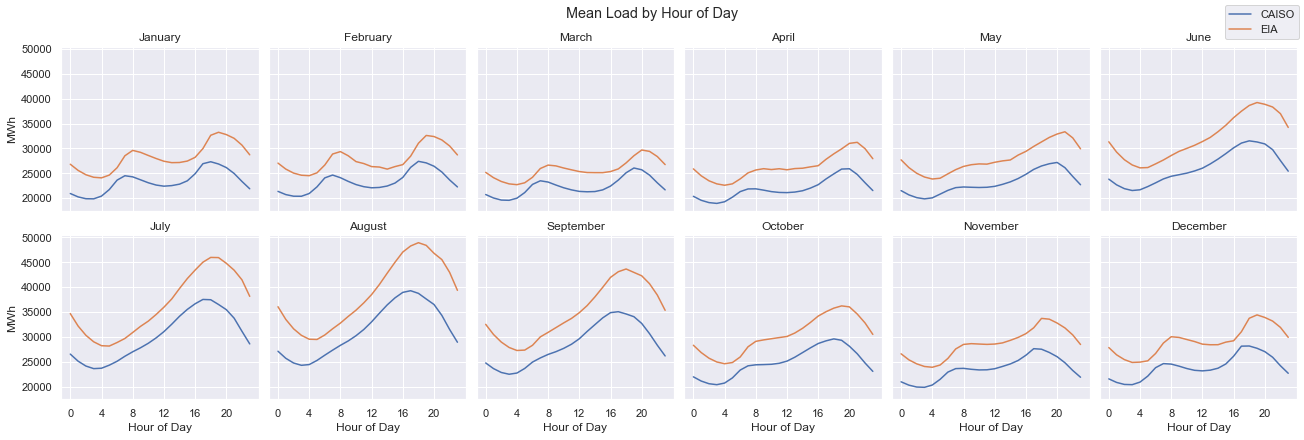

In [22]:
hourly_mu_plots('load')

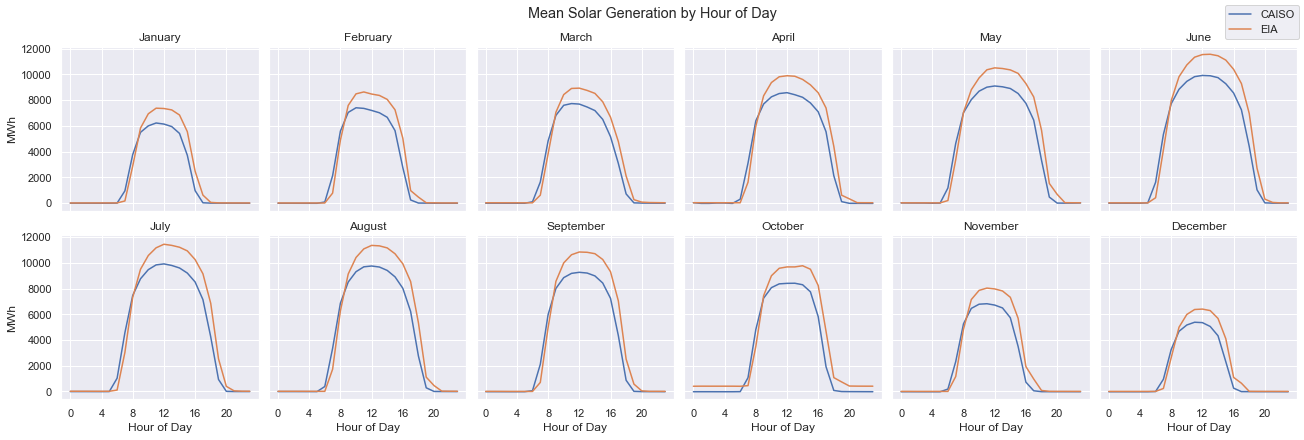

In [23]:
hourly_mu_plots('solar')

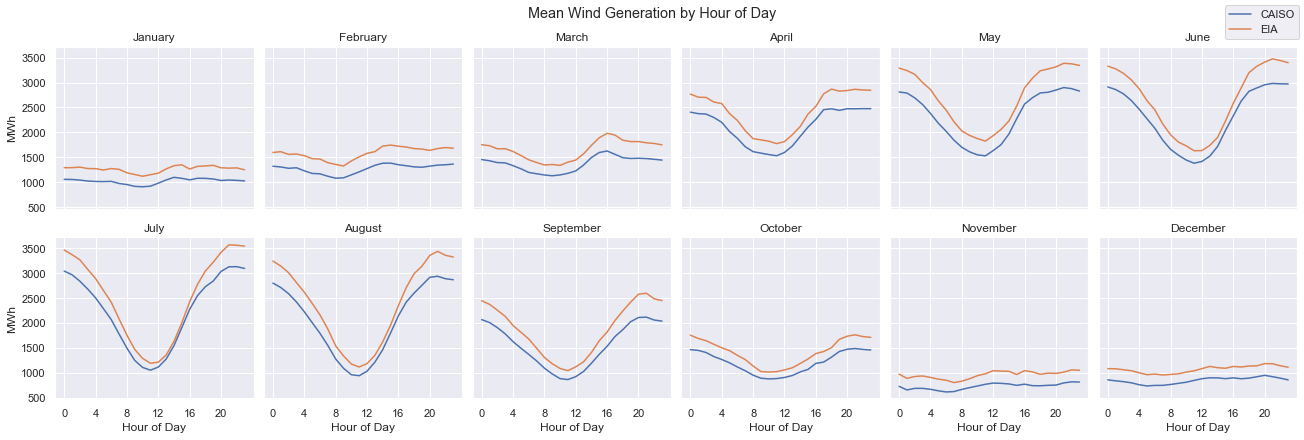

In [24]:
hourly_mu_plots('wind')

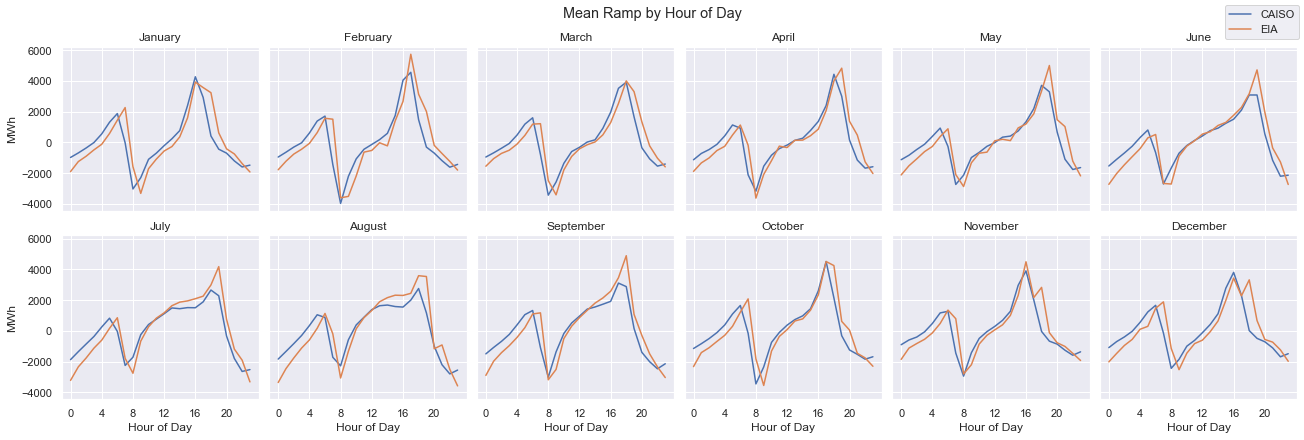

In [25]:
hourly_mu_plots('ramp')

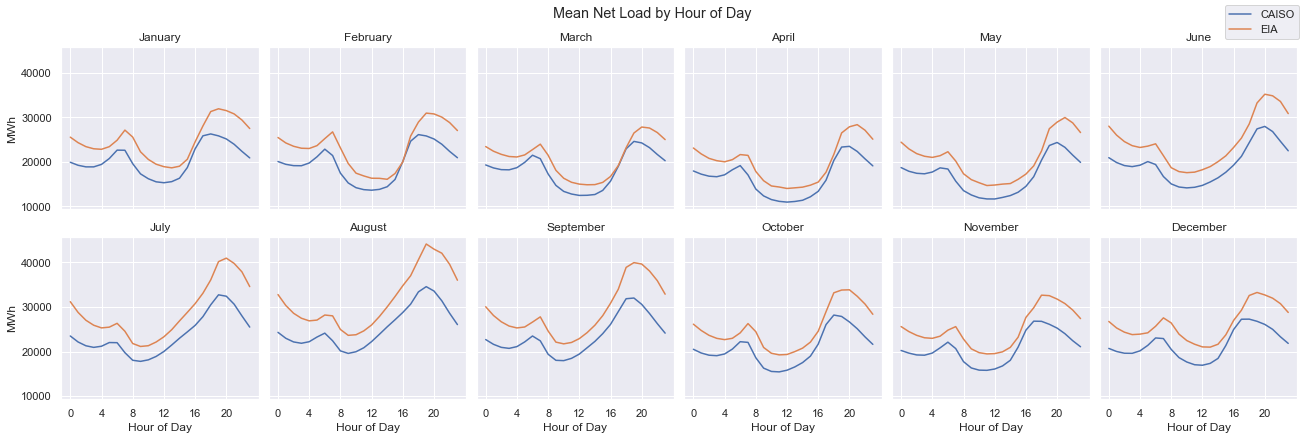

In [26]:
hourly_mu_plots('net_load')